<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/learn/gradient%20descent%20for%20solving%20params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Discussion with Meng, whether neurons will represent the certain value we want to approximate.

#### Try to approximate $y = a x^2 + b x + c$. To mimic real world data with error, will generate data $y_{obs} = y + err$, in which $err \sim N (0, \sigma^2)$

In [1]:
import torch
from torch import nn, optim
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

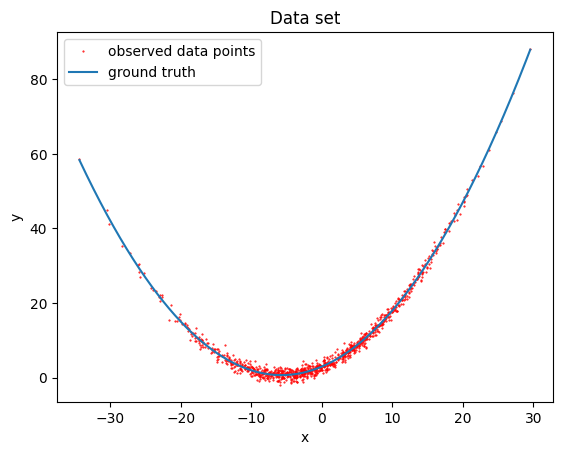

In [2]:
# Create pseudo data set first, the parameters could be changable
N = 1000 # data set size
a = 0.07
b = 0.8
c = 3
sigma = 1 # standard deviation of err
MAX_ABS = 10
#######################################################################
def true_function(x):
  return a * x * x + b * x + c

err = torch.randn(N) * sigma * sigma
x = torch.randn(N) * MAX_ABS
y = true_function(x)
y_obs = y + err # y_obs is the observed data with error
dataset = data.TensorDataset(x, y_obs)
loader = data.DataLoader(dataset, batch_size=64, shuffle=True)

x_temp = np.arange(x.min().item(), x.max().item(), 0.02)

# plot the pseudo data set
plt.plot(x, y_obs, 'ro', label='observed data points', markersize=0.5)
plt.plot(x_temp, true_function(x_temp), label='ground truth')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data set')
plt.legend(loc=2)
plt.show()
plt.close()

In [3]:
# Model structure
class NNTest(nn.Module):
    def __init__(self):
        super().__init__()
        # initialization of parameters
        self.a = torch.nn.Parameter(torch.tensor(0.1))
        self.b = torch.nn.Parameter(torch.tensor(0.1))
        self.c = torch.nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        return self.a * x * x + self.b * x  + self.c

  0%|          | 1/10000 [00:00<30:31,  5.46it/s]

Epoch: 1, Loss: 88.923
Here predicted value: a(true=0.070): 0.097, b(true=0.8): 0.103, c(true=3): 0.098


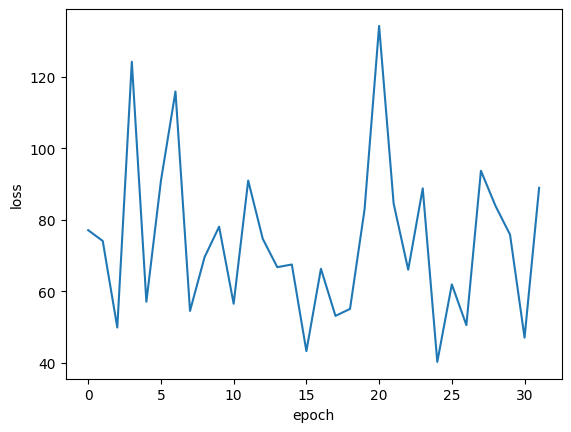

 20%|██        | 2000/10000 [01:29<03:46, 35.30it/s]

Epoch: 2001, Loss: 1.218
Here predicted value: a(true=0.070): 0.070, b(true=0.8): 0.804, c(true=3): 2.916


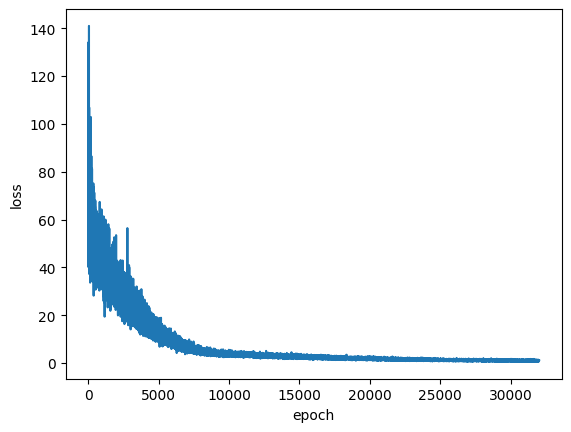

 31%|███       | 3072/10000 [02:03<04:38, 24.86it/s]


early stop, training finished


In [4]:
MAX_EPOCH = 10000
model_path_ = 'test.pt'
patience = 1000
verbose_freq = 2000
model = NNTest()
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()
loss_all = []

min_loss = np.inf
min_epoch = 0

for epoch in tqdm(range(MAX_EPOCH), total=MAX_EPOCH):
    model.train()
    for inp, out in loader:
        opt.zero_grad()
        loss = loss_fn(model(inp), out)
        loss.backward()
        opt.step()
        for p in model.parameters(): p.data.clamp_(0.0, 100)
        loss_all.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), model_path_)
    if epoch - min_epoch > patience: print('\nearly stop, training finished'); break

    if (epoch - 1) % verbose_freq == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.3f}');
        print(f'Here predicted value: a(true={a:.3f}): {model.a.item():.3f},',
              f'b(true={b}): {model.b.item():.3f}, c(true={c}): {model.c.item():.3f}')
        plt.plot(loss_all);
        plt.xlabel('epoch'); plt.ylabel('loss')
        plt.show(); plt.close()

In [5]:
def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))
    print(f'Best model: | predicted value: a(true={a:.3f}): {model.a.item():.3f}',
          f'| b(true={b}): {model.b.item():.3f} | c(true={c}): {model.c.item():.3f}')

load_model(model, model_path_)

model.eval()
pred_list = []
inp_list = []
oup_list = []
for inp, oup in loader:
    inp_list += inp.detach().numpy().tolist()
    oup_list += oup.detach().numpy().tolist()
    pred = model(inp)
    pred_list += pred.detach().numpy().tolist()



load model from path:  test.pt
Best model: | predicted value: a(true=0.070): 0.070 | b(true=0.8): 0.804 | c(true=3): 2.967


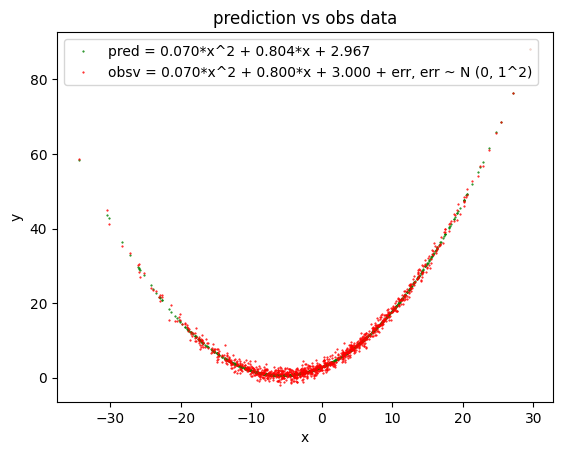

In [6]:
label_pred = f'pred = {model.a.item():.3f}*x^2 + {model.b.item():.3f}*x + {model.c.item():.3f}'
label_obs = f'obsv = {a:.3f}*x^2 + {b:.3f}*x + {c:.3f} + err, err ~ N (0, {sigma}^2)'
plt.plot(inp_list, pred_list, 'go', label=label_pred, markersize=0.5)
# plt.plot(x_temp, true_function(x_temp), label='ground truth')

plt.plot(inp_list, oup_list,  'ro', label=label_obs, markersize=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.title('prediction vs obs data')
plt.legend(loc=2)
plt.show()
plt.close()

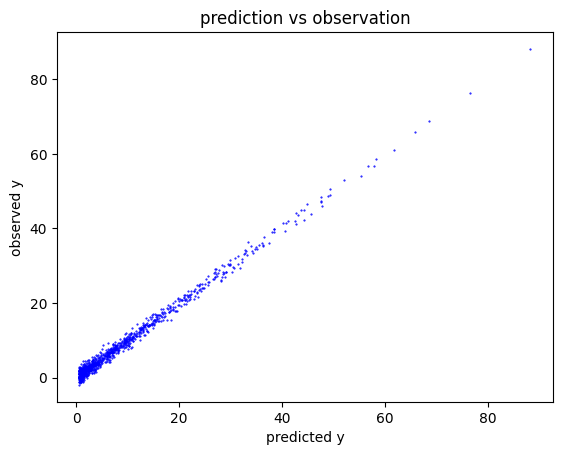

In [7]:
plt.plot(pred_list, oup_list, 'bo', markersize = 0.5)
plt.xlabel('predicted y')
plt.ylabel('observed y')
plt.title('prediction vs observation')
plt.show(); plt.close()